## MODELO

In [271]:
import seaborn as sns
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn import linear_model 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import model_matrix
from sklearn.datasets import load_wine
from sklearn.model_selection import GridSearchCV
import nums_from_string

In [343]:
datos = pd.read_csv("sube-2023-regresion.csv")

#datos

In [273]:
colectivos = datos[(datos["TIPO_TRANSPORTE"] == "COLECTIVO") & (datos["PROVINCIA"] == "JN") 
                   & (datos["AMBA"] == "SI")  & (datos["DATO_PRELIMINAR"] == "NO")]

columnas = colectivos["LINEA"].unique()

In [274]:
pasajeros = pd.DataFrame()

for columna in columnas:
    linea = colectivos[colectivos["LINEA"] == columna][["DIA_TRANSPORTE", "CANTIDAD"]]
    linea = linea.set_index("DIA_TRANSPORTE").rename(columns = {"CANTIDAD" : columna})
    pasajeros = pd.concat([pasajeros, linea], axis = 1)


In [275]:
print(len(pasajeros.columns)-(pasajeros.isnull().sum()/pasajeros.isnull().sum()).sum())

124.0


In [276]:
for columna in pasajeros.columns:
    if pasajeros[columna].isnull().sum() != 0:
        pasajeros = pasajeros.drop(columna, axis = 1)

pasajeros.isnull().sum().sum() == 0
#Con esto chequea que no tenga ningun null, el primer sum lo hace por linea, el segundo entre todas las lineas

True

In [277]:
#Para facilitar lectura y obtencion de distintos datos voy a usar el paquete nums_from_string, para poder asignar a cada linea unicamente
# su numero como identificador de la columna, pero que a su vez los numeros queden como strings

columnas_nums = []

for i in pasajeros.columns:
    num = nums_from_string.get_nums(i)
    columnas_nums += num

columnas_nums = ['L'+str(n) for n in columnas_nums]

pasajeros.columns = columnas_nums

#Chequear que queden los numeros y pasados como string
#pasajeros
#type(pasajeros.columns[0])

La idea para armar el modelo fue averiguar las terminales de la linea 9, que son Retiro y Villa Caraza, y encontrar lineas de colectivos que pasen por la zona. La hipotesis es que las paradas que son mas cercanas a las terminales suelen tener mas poblacion de pasajeros que las intermedias, y en particular para un colectivo que viene desde la provincia. Por lo tanto para un primer modelo se aproximara por lineas que tengan paradas cercanas a las de las terminales de la linea 9.

RETIRO: 
5, 6, 7, 9, 20, 21, 22, 23, 26, 33, 45, 50, 51, 54, 56, 61, 62, 70, 75, 91, 100, 
101, 106, 108, 115, 126, 129, 130, 132, 143, 150, 152 y 195

VILLA CARAZA:
9, 158, 247 y 520 

Con estas lineas mi idea es averiguar cuales son las que mueven mas pasajeros en promedio, y tambien con una analisis de correlacion ver si se relacionan linealmente con la linea 9.


In [278]:
retiro = [5, 6, 7, 20, 21, 22, 23, 26, 33, 45, 50, 51, 54, 56, 61, 62, 70, 75, 91, 100, 
101, 106, 108, 115, 126, 129, 130, 132, 143, 150, 152, 195]

lineas_retiro = ['L'+str(x) for x in retiro if 'L'+str(x) in pasajeros.columns]

villa_caraza = [158, 247, 520]

lineas_villa_caraza = ['L'+str(x) for x in villa_caraza if 'L'+str(x) in pasajeros.columns]


In [279]:
ret_vil = ['L9'] + lineas_retiro + lineas_villa_caraza
pasajeros_ret_vil = pasajeros[ret_vil]
pasajeros_ret_vil.head()

,L9,L6,L7,L20,L21,L22,L23,L26,L33,L45,...,L106,L108,L115,L126,L130,L132,L143,L150,L152,L158
DIA_TRANSPORTE,,,,,,,,,,,,,,,,,,,,,
2023-01-01,5644,2449,2184,2617,11235,2202,1033,5399,8076,6517,...,4921,1972,2951,7052,4780,9691,2249,4033,14533,2226
2023-01-02,23284,10486,12774,11934,55611,13823,8136,19374,33017,25514,...,26317,13084,16797,26766,29406,38528,13392,16375,52104,12302
2023-01-04,25405,12193,13949,13366,61721,16206,9507,21889,35216,27563,...,30053,16166,17558,30547,34393,41682,14806,17898,59989,13686
2023-01-05,26489,12888,14668,12929,62510,16863,9864,22505,36858,29314,...,30230,15774,19357,32140,33535,44929,15512,19526,60288,15533
2023-01-06,26458,12703,14199,12955,63528,16846,10012,22730,36805,28809,...,30021,16065,19146,31701,31968,44337,15482,19216,57939,15934


In [280]:
pasajeros_ret_vil.corr()[['L9']].idxmin().iloc[0]

'L158'

In [283]:
mas_corr = []
copia = pasajeros_ret_vil.corr()[['L9']].copy()
copia = copia.drop(index = 'L9', axis = 1)

for i in range(0,12,1):
    a = copia.idxmax().iloc[0]
    copia = copia.drop(index = a, axis = 1)
    mas_corr.append(a)

mas_corr
#Las 12 lineas que mas correlacion tienen con la linea 9

['L101',
 'L7',
 'L150',
 'L100',
 'L115',
 'L106',
 'L6',
 'L91',
 'L56',
 'L50',
 'L108',
 'L130']

In [284]:
mas_pas = []
copia = pasajeros_ret_vil.copy()
copia = copia.drop('L9', axis = 1)

for i in range(0,12,1):
    a = copia.sum().idxmax()
    copia = copia.drop(a, axis = 1)
    mas_pas.append(a)

mas_pas 
#Las 12 lineas que mas gente mueven pasan por Retiro

['L152',
 'L21',
 'L132',
 'L130',
 'L33',
 'L101',
 'L126',
 'L106',
 'L100',
 'L45',
 'L91',
 'L26']

In [285]:
mejores = list(set(mas_corr) & set(mas_pas))
mejores

['L101', 'L106', 'L100', 'L91', 'L130']

La idea es utilizar colectivos que tengan una gran correlacion con la linea 9 y al mismo tiempo esten entre las lineas que mas gente mueven, se encontro que entre las 12 primeras con mayor correlacion y con mayor cantidad de pasajeros coinciden 5 lineas, por lo tanto seria interesante utilizar estas para armar un modelo. 
Se utilizara un modelo de Regresion Ridge, con un GridSearchCV para encontrar un alpha optima.

In [309]:
X, y = pasajeros[pasajeros.drop('L9', axis = 1).columns], pasajeros[['L9']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)


In [310]:
formula = ' ~ L100 + L91 + L101 + L130 + L106'
X1_train = model_matrix(formula, X_train)
X1_test = model_matrix(formula, X_test)

In [311]:
alpha = {"alpha": np.logspace(-5,5,100)}

In [312]:
gs = GridSearchCV(Ridge(fit_intercept = False), alpha, cv = 5, scoring = "neg_root_mean_squared_error", return_train_score = True)
gs.fit(X1_train, y_train)

gs.best_params_, gs.best_score_

({'alpha': 4.534878508128582}, -1915.1341045672016)

In [313]:
cv_results_ = pd.DataFrame(gs.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1
cv_results_

,param_alpha,mean_test_score,mean_train_score
0,0.00001,1920.109149,1912.066407
1,0.000013,1920.109140,1912.066407
2,0.000016,1920.109129,1912.066407
3,0.00002,1920.109115,1912.066407
4,0.000025,1920.109097,1912.066407
...,...,...,...
95,39442.060594,1940.655526,1944.850337
96,49770.235643,1940.658827,1944.854011
97,62802.914418,1940.661236,1944.856922
98,79248.289835,1940.662883,1944.859230


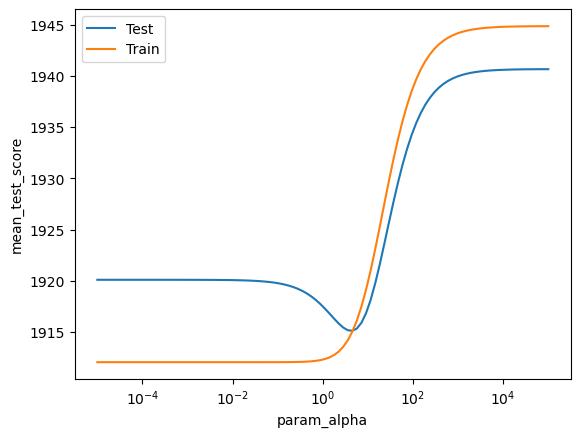

In [314]:
sns.lineplot(x = "param_alpha", y = "mean_test_score", data = cv_results_, label = "Test")
sns.lineplot(x = "param_alpha", y = "mean_train_score", data = cv_results_, label = "Train")
plt.xscale("log")
plt.show()

In [320]:
y_pred = gs.predict(X1_test)

r2 = r2_score(y_test, y_pred)
recm = np.sqrt(mean_squared_error(y_test, y_pred))
r2, recm

(0.9661710486806753, 1917.9443773477851)

In [321]:
test = X1_test.copy()
test["y_test"] = y_test
test["y_pred"] = y_pred
test["Residuos"] = y_test - y_pred

In [338]:
residuo_medio = np.sqrt(test["Residuos"]**2).mean()
test_mean = test["y_test"].mean() 
pred_mean = test["y_pred"].mean() 
print("El promedio de los datos de test es:", {test_mean})
print("El promedio de los datos de prediccion es:", {round(pred_mean, 2)})
print("La diferencia entre los promedios es de:", {round(round(pred_mean, 2) - test_mean, 2)})
print("El promedio de los residuos es de:", {round(residuo_medio, 2)})

El promedio de los datos de test es: {24181.84}
El promedio de los datos de prediccion es: {24240.54}
La diferencia entre los promedios es de: {58.7}
El promedio de los residuos es de: {1425.62}


Se cree que la diferencia entre el promedio de los residuos y la diferencia de los promedio de datos de test y de prediccion se deben a outliers en los datos de la linea 9, hay dias donde los pasajeros son muy bajos comparado a la media.

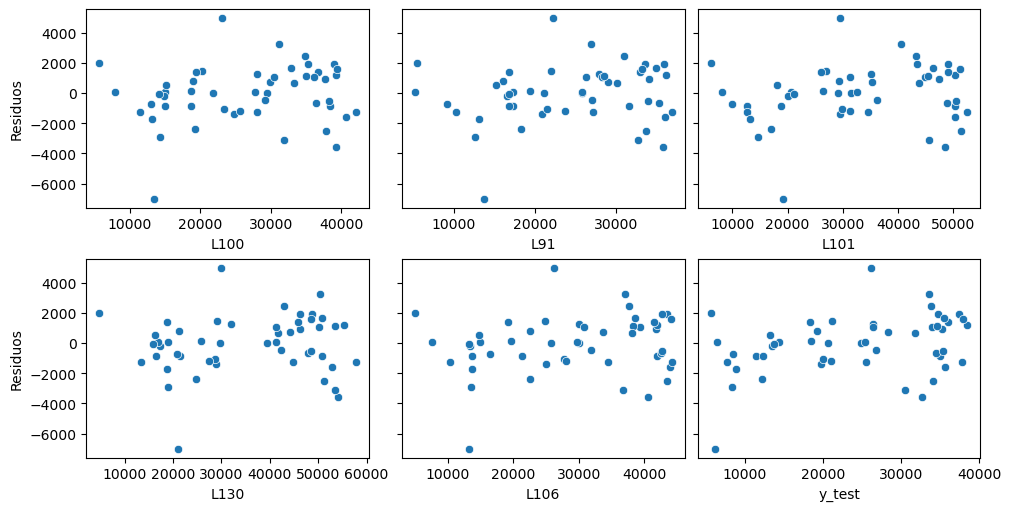

In [323]:
fig, axs = plt.subplots(2, 3, figsize = (10, 5), sharey = True, layout='constrained')
for versus, ax in zip(['L100', 'L91', 'L101', 'L130', 'L106', 'y_test'], axs.flatten()):
    sns.scatterplot(x = versus, y = "Residuos", data = test, ax = ax)

Este modelo tiene un error bajo relativamente, el promedio de los datos de test respecto del promedio de los predecidos es de  

Colectivos metrobus 9 de julio: 
9, 10, 17, 39, 45, 59, 67, 70, 91, 98, 100, 129

La idea de este segundo modelo es utilizar los datos de colectivos que pasan por el metrobus de 9 de julio, donde la linea 9 realiza gran parte de su recorrido